In [ ]:
import sys
sys.path.append("..")
import jax
import jax.random as jr
import numpy as np
import equinox as eqx # pytree utilities
from rnn_jax.cells import LongShortTermMemory # equinox wrapper
from rnn_jax.cells import LongShortTermMemoryCell # custom
from rnn_jax.layers import RNNEncoder
import matplotlib.pyplot as plt
import timeit

In [16]:
key = jr.key(0)

In [18]:
def timeit_style_print(times, number=1, repeat=None):
    """
    Print %timeit-style summary given an array of timing samples.
    `times` should be a list/array of durations in seconds.
    """
    import numpy as np
    times = np.array(times)
    if repeat is None:
        repeat = len(times)
    best = times.min()

    # unit formatting like IPython %timeit
    def fmt(t):
        if t < 1e-6:
            return f"{t * 1e9:.2f} ns"
        elif t < 1e-3:
            return f"{t * 1e6:.2f} µs"
        elif t < 1:
            return f"{t * 1e3:.2f} ms"
        else:
            return f"{t:.2f} s"
    
    print(f"{number} loop(s), best of {repeat}: {fmt(best)} per loop")


EQX times:
1000 loop(s), best of 20: 34.03 ms per loop
Custom lstm times:
1000 loop(s), best of 20: 36.39 ms per loop


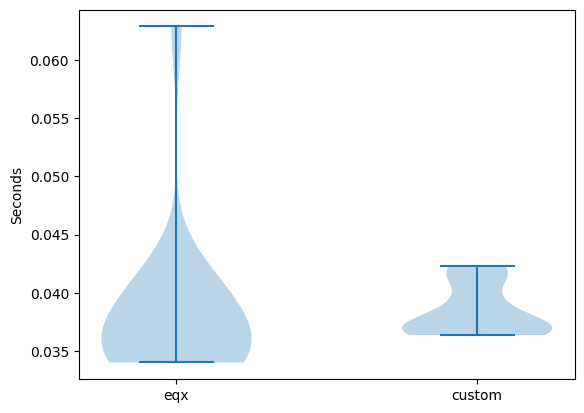

In [22]:
# Small dim,unbatched
SEQ_LEN = 10
IDIM = 1
HDIM = 10

lstm_eqx = RNNEncoder(LongShortTermMemory(IDIM, HDIM, key=key))
lstm_custom = RNNEncoder(LongShortTermMemoryCell(IDIM, HDIM, key=key))

x = jr.uniform(key, (10, 1))

lstm_eqx = eqx.filter_jit(lstm_eqx)
lstm_custom = eqx.filter_jit(lstm_custom)

def bench_eqx():
    out = lstm_eqx(x)
    jax.tree_util.tree_map(lambda y: y.block_until_ready(), out)

def bench_custom():
    out = lstm_custom(x)
    jax.tree_util.tree_map(lambda y: y.block_until_ready(), out)

# Warm-up
bench_eqx()
bench_custom()


# Collect samples
eqx_times = timeit.Timer(bench_eqx).repeat(repeat=20, number=1000)
custom_times = timeit.Timer(bench_custom).repeat(repeat=20, number=1000)

print("EQX times:")
timeit_style_print(eqx_times, number=1000)
print("Custom lstm times:")
timeit_style_print(custom_times, number=1000)
plt.figure()
plt.violinplot([eqx_times, custom_times])
plt.xticks([1, 2], ["eqx", "custom"])
plt.ylabel("Seconds")
plt.show()


EQX times:
100 loop(s), best of 20: 39.62 ms per loop
Custom lstm times:
100 loop(s), best of 20: 46.56 ms per loop


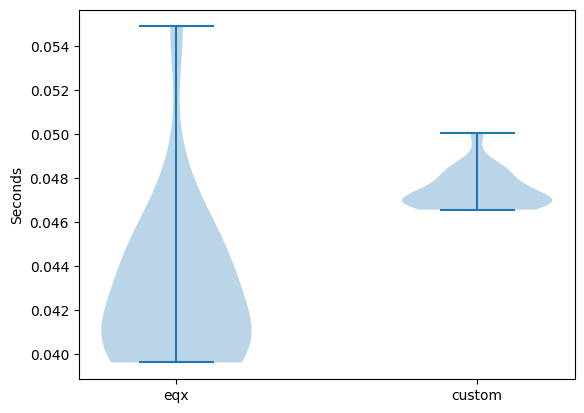

In [23]:
#medium dim,unbatched
SEQ_LEN = 100
IDIM = 7
HDIM = 128

lstm_eqx = RNNEncoder(LongShortTermMemory(IDIM, HDIM, key=key))
lstm_custom = RNNEncoder(LongShortTermMemoryCell(IDIM, HDIM, key=key))

x = jr.uniform(key, (SEQ_LEN, IDIM))

lstm_eqx = eqx.filter_jit(lstm_eqx)
lstm_custom = eqx.filter_jit(lstm_custom)

def bench_eqx():
    out = lstm_eqx(x)
    jax.tree_util.tree_map(lambda y: y.block_until_ready(), out)

def bench_custom():
    out = lstm_custom(x)
    jax.tree_util.tree_map(lambda y: y.block_until_ready(), out)

# Warm-up
bench_eqx()
bench_custom()


# Collect samples
eqx_times = timeit.Timer(bench_eqx).repeat(repeat=20, number=100)
custom_times = timeit.Timer(bench_custom).repeat(repeat=20, number=100)

print("EQX times:")
timeit_style_print(eqx_times, number=100)
print("Custom lstm times:")
timeit_style_print(custom_times, number=100)
plt.figure()
plt.violinplot([eqx_times, custom_times])
plt.xticks([1, 2], ["eqx", "custom"])
plt.ylabel("Seconds")
plt.show()



EQX times:
10 loop(s), best of 7: 844.77 ms per loop
Custom lstm times:
10 loop(s), best of 7: 1.01 s per loop


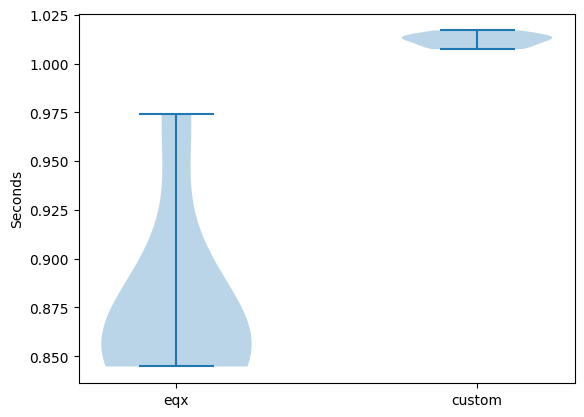

In [28]:
#medium dim, batched
BATCH_SIZE = 64
SEQ_LEN = 100
IDIM = 7
HDIM = 128

lstm_eqx = RNNEncoder(LongShortTermMemory(IDIM, HDIM, key=key))
lstm_custom = RNNEncoder(LongShortTermMemoryCell(IDIM, HDIM, key=key))

x = jr.uniform(key, (BATCH_SIZE, SEQ_LEN, IDIM))

lstm_eqx = eqx.filter_vmap(lstm_eqx)
lstm_custom = eqx.filter_vmap(lstm_custom)

def bench_eqx():
    out = lstm_eqx(x)
    jax.tree_util.tree_map(lambda y: y.block_until_ready(), out)

def bench_custom():
    out = lstm_custom(x)
    jax.tree_util.tree_map(lambda y: y.block_until_ready(), out)

# Warm-up
bench_eqx()
bench_custom()


# Collect samples
eqx_times = timeit.Timer(bench_eqx).repeat(repeat=7, number=10)
custom_times = timeit.Timer(bench_custom).repeat(repeat=7, number=10)

print("EQX times:")
timeit_style_print(eqx_times, number=10)
print("Custom lstm times:")
timeit_style_print(custom_times, number=10)
plt.figure()
plt.violinplot([eqx_times, custom_times])
plt.xticks([1, 2], ["eqx", "custom"])
plt.ylabel("Seconds")
plt.show()



EQX times:
10 loop(s), best of 7: 2.50 s per loop
Custom lstm times:
10 loop(s), best of 7: 2.93 s per loop


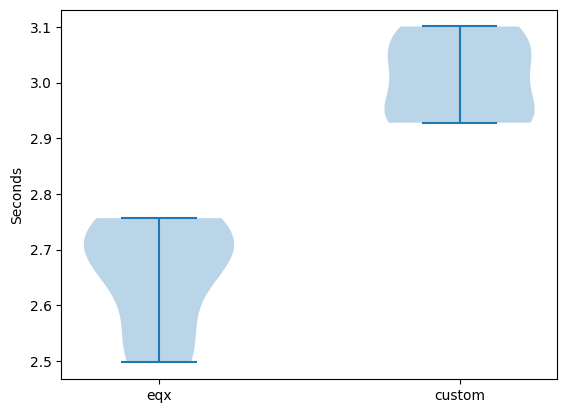

In [32]:
# bigger dim, batched, bigger seqs
BATCH_SIZE = 512
SEQ_LEN = 1024
IDIM = 8
HDIM = 512

lstm_eqx = RNNEncoder(LongShortTermMemory(IDIM, HDIM, key=key))
lstm_custom = RNNEncoder(LongShortTermMemoryCell(IDIM, HDIM, key=key))

x = jr.uniform(key, (BATCH_SIZE, SEQ_LEN, IDIM))

lstm_eqx = eqx.filter_vmap(lstm_eqx)
lstm_custom = eqx.filter_vmap(lstm_custom)


def bench_eqx():
    out = lstm_eqx(x)
    jax.tree_util.tree_map(lambda y: y.block_until_ready(), out)

def bench_custom():
    out = lstm_custom(x)
    jax.tree_util.tree_map(lambda y: y.block_until_ready(), out)

# Warm-up
bench_eqx()
bench_custom()

# Collect samples
eqx_times = timeit.Timer(bench_eqx).repeat(repeat=7, number=1)
custom_times = timeit.Timer(bench_custom).repeat(repeat=7, number=1)

print("EQX times:")
timeit_style_print(eqx_times, number=10)
print("Custom lstm times:")
timeit_style_print(custom_times, number=10)
plt.figure()
plt.violinplot([eqx_times, custom_times])
plt.xticks([1, 2], ["eqx", "custom"])
plt.ylabel("Seconds")
plt.show()




Custom code is $20\%$ slower on the biggest benchmark on M4Pro chip CPU. 

Can this be a good price to have a more flexible model?